### Gravity Spy tutorial 1: how can we classify a glitch?

author: Melissa Lopez

email: m.lopez@uu.nl

In [17]:
from gwpy.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import requests
import sys
#FIXME: your path to your Gravity Spy repo
path_to_repo = "/home/melissa.lopez/GravitySpy/"
sys.path.insert(0, path_to_repo)
from gravityspy.classify import classify
from gravityspy.utils import utils
from gravityspy.plot import plot_qtransform
warnings.filterwarnings('ignore')

In this tutorial we will fetch real GW data and learn how to run [`Gravity Spy` pipeline](https://iopscience.iop.org/article/10.1088/1361-6382/aa5cea). Gravity Spy is a project that uses crowdsourcing and machine learning to classify glitches in LIGO data, helping identify and eliminate noise, improving gravitational-wave observations by combining human and algorithmic classification methods.

In Zenodo we can find [`Gravity Spy` datasets](https://zenodo.org/records/5649212) that contains `Gravity Spy` classifications of LIGO glitches from observing runs O1, O2, and O3 (split into O3a and O3b). It includes noise events identified by the [`Omicron` trigger pipeline](https://www.sciencedirect.com/science/article/pii/S2352711020303332), with signal-to-noise ratios above 7.5 and frequencies between 10 Hz and 2048 Hz, using Omega scans.

In [8]:
# URL of the CSV file
url = "https://zenodo.org/records/5649212/files/H1_O3a.csv?download=1"
file_to_store = './H1_O3a.csv' # Fix this to your desired path and name
# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Write the content of the response to a local CSV file
    with open(file_to_store, "wb") as file:
        file.write(response.content)
    
    glitches = pd.read_csv(file_to_store) # if succesful we load it
    print("File downloaded successfully.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully.


Exploring the glitch data set we can see that it has the following columns.

In [9]:
glitches.columns

Index(['event_time', 'ifo', 'peak_time', 'peak_time_ns', 'start_time',
       'start_time_ns', 'duration', 'peak_frequency', 'central_freq',
       'bandwidth', 'channel', 'amplitude', 'snr', 'q_value', 'gravityspy_id',
       '1400Ripples', '1080Lines', 'Air_Compressor', 'Blip', 'Chirp',
       'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation',
       'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch',
       'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips',
       'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line',
       'Whistle', 'ml_label', 'ml_confidence', 'url1', 'url2', 'url3', 'url4'],
      dtype='object')

This is a brief explanation of these columns:

- **event_time**: Time of the event detection.
- **ifo**: Interferometer name (e.g., LIGO Hanford is H1).
- **peak_time**: Time of the peak signal.
- **peak_time_ns**: Peak signal time in nanoseconds.
- **start_time**: Start time of the event.
- **start_time_ns**: Start time in nanoseconds.
- **duration**: Duration of the glitch.
- **peak_frequency**: Peak frequency of the glitch.
- **central_freq**: Central frequency of the glitch.
- **bandwidth**: Bandwidth of the glitch.
- **channel**: The data channel where the glitch was detected.
- **amplitude**: Amplitude of the glitch signal.
- **snr**: Signal-to-noise ratio of the event.
- **q_value**: Quality factor of the glitch.
- **gravityspy_id**: Unique identifier for the gravity spy classification.

Then there is a bunch of glitch names such as:

**'1400Ripples', '1080Lines', 'Air_Compressor', 'Blip', 'Chirp',
       'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation',
       'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch',
       'None_of_the_Above', 'Paired_Doves', 'Power_Line', 'Repeating_Blips',
       'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line',
       'Whistle'**

Last but not least, we have the following columns:

- **ml_label**: The label assigned by the machine learning model.
- **ml_confidence**: Confidence score for the machine learning model's classification.
- **url1, url2, url3, url4**: URLs linking to additional resources or data related to the event.

We will select the first glitch to reclasify it with `Gravity Spy`. For this we select `peak_time` as this will correspond roughly to the center of the glitch.

In [10]:
j =  2 # second glitch
event_time = glitches.iloc[j]['peak_time'] + 10**(-9)*glitches.iloc[j]['peak_time_ns']
start = event_time - 20 # we load 20s before and after to avoid border effects
end = event_time + 20

We also need information about the detector to fetch the data.

In [11]:
ifo = glitches.iloc[0]['ifo'] # need to fetch data 
channel_name = f'{ifo}:GDS-CALIB_STRAIN' # to use later
# Now we call the data with gpwy
glitch_series = TimeSeries.fetch_open_data(ifo, start, end)

With `glitch_series` we can already classify the glitch using `classify` function. However, I would like first to explain what is happening under the hood.

`Gravity Spy` is a convolutional neural network, which means that it processes images, which in GW context implies time-frequency representations known as spectrograms. The configuration of `Gravity Spy` to generate these spectrograms (and others) is encoded within `GravitySpyConfigFile`. So first we need to call this specific configuration.

In [12]:
config = utils.GravitySpyConfigFile()
plot_time_ranges = config.plot_time_ranges
plot_normalized_energy_range = config.plot_normalized_energy_range

- `config `: Creates an instance of the `GravitySpyConfigFile` class from the `utils` module, likely used for managing configuration settings.

- `plot_time_ranges`: defines time intervals for plotting or analysis.

- `plot_normalized_energy_range`: specifies a range for normalized energy values in plots or analysis, i.e. the z-axis of the spectrogram.


Now we can make the spectrograms using `make_q_scans` and plot them.

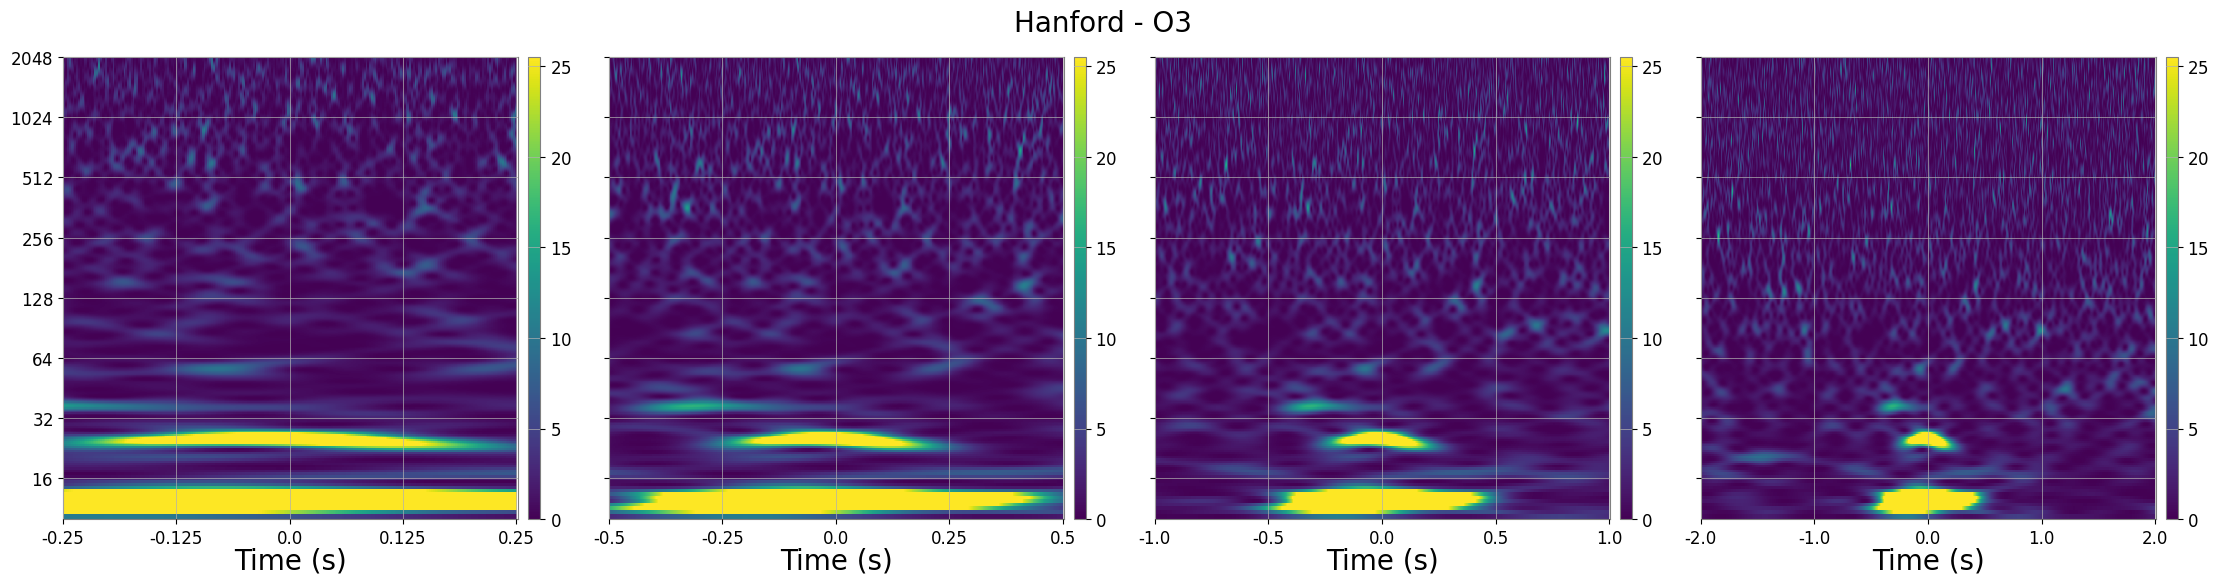

In [13]:
specsgrams, q_value = utils.make_q_scans(event_time=event_time,
                                         timeseries=glitch_series,
                                         config=config,
                                         channel_name=channel_name)

ind_fig_all, super_fig = plot_qtransform(specsgrams,
                                         plot_normalized_energy_range,
                                         plot_time_ranges,
                                         ifo,
                                         event_time)
super_fig # this combines the 4 different time resolutions of Gravity Spy

`super_fig` is the visualization of what `Gravity Spy` is classifying. If we directly want to simply classify our glitch, we use `classify` function as seen below.

In [14]:
# I use Siddharth Soni's model but the repo has more models to try!
path_to_model = f'{path_to_repo}/models/sidd-cqg-paper-O3-model.h5'

results_glitch = classify(event_time=event_time,
                          channel_name=channel_name,
                          path_to_cnn=path_to_model,
                          timeseries=glitch_series)


2025-03-15 10:10:29.499596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-15 10:10:29.499673: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-15 10:10:29.499719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter4): /proc/driver/nvidia/version does not exist
2025-03-15 10:10:29.500614: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


It is relevant to note that folder named `plots` was created to classify our glitch. If you classify multiple glitches `Gravity Spy` will classify _all_ images within forming a table. They will have the following columns.

In [15]:
results_glitch.columns

<TableColumns names=('1080Lines','1400Ripples','Air_Compressor','Blip','Blip_Low_Frequency','Chirp','Extremely_Loud','Fast_Scattering','Helix','Koi_Fish','Light_Modulation','Low_Frequency_Burst','Low_Frequency_Lines','No_Glitch','Paired_Doves','Power_Line','Repeating_Blips','Scattered_Light','Scratchy','Tomte','Violin_Mode','Wandering_Line','Whistle','Filename1','Filename2','Filename3','Filename4','gravityspy_id','ml_label','ml_confidence','q_value')>

- **Glitch columns**: the different glitch columns provide the probability of being a certain class. 
- **Filename columns**: provide the path to the stored images.
- **gravityspy_id**: is the GPS time of the glitch
- **ml_label**: this is the class with maximum probability 
- **ml_confidence**: this is the maximum probability of the selected class
- **q_value**: the Q-value to compute the Q-transform.

In [16]:
results_glitch['ml_label'].value[0], results_glitch['ml_confidence'].value[0]


('Low_Frequency_Burst', 0.9973794)

Then this is a `Low_Frequency_Burst` with a probability >0.99

This is the end of the first `Gravity Spy` tutorial. Next time, we will create a simulated glitch and use `Gravity Spy` to classify it.